<a href="https://colab.research.google.com/github/PavelNovikov888/Anomaly_Detection/blob/master/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%D0%94%D0%B5%D1%82%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%BD%D0%BE%D0%BC%D0%B0%D0%BB%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install undetected-chromedriver --quiet
!pip install selenium --quiet

# ПОСТАНОВКА ЗАДАЧИ

Оценить, есть ли влияние от рекламы чая «Ахмад» в передаче «Что? Где? Когда?» на его продажи.
* Произведён парсинг данных о датах проведения передачи «Что? Где? Когда?»
* Построена модель, предсказывающая значение временного ряда продаж. Показано, что нет положительного misprediction.
* Построен boxplot, указано, что нет аномалии роста продаж после передачи.
* Сделана попытка кластеризации точек продаж (по всем трём вендорам).

Нужны даты проведения передач. Откуда их взять?
Стоит начать с статистических методов.
А если попробовать как-то предсказать продажи?
Давайте попробуем кластеризовать!

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

#используем версию webdriver, которая необнаруживается анти-ботами
import undetected_chromedriver as webdriver
import time

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Start the Chrome driver
driver = webdriver.Chrome(options=options)

In [3]:
#В колабе импортируем все необходимые библиотеки
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1i77jXo_zDgkFr0knVkRjRLO8_MGptfBL"})
# https://drive.google.com/file/d/1i77jXo_zDgkFr0knVkRjRLO8_MGptfBL/view?usp=sharing
download.GetContentFile("tea_demand.zip")

In [4]:
# загрузим данные для анализа отказа системы регулирования температуры в помещении
df = pd.read_csv("tea_demand.zip", sep= '\t')
# ipton — 29; ahmad — 178; may — 5152
df['brand_id'].value_counts()

5152    153
178     153
29      153
Name: brand_id, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   brand_id        459 non-null    int64 
 1   date            459 non-null    object
 2   receipts_count  459 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.9+ KB


In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.head()

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185


In [8]:
df.nunique()

brand_id            3
date              153
receipts_count    313
dtype: int64

In [9]:
print(df.describe(datetime_is_numeric=True))

          brand_id                           date  receipts_count
count   459.000000                            459      459.000000
mean   1786.333333  2016-09-15 00:00:00.000000256      362.209150
min      29.000000            2016-07-01 00:00:00       73.000000
25%      29.000000            2016-08-08 00:00:00      186.500000
50%     178.000000            2016-09-15 00:00:00      339.000000
75%    5152.000000            2016-10-23 00:00:00      529.000000
max    5152.000000            2016-11-30 00:00:00     1301.000000
std    2383.260539                            NaN      220.350485


# Парсинг

In [10]:
# Navigate to a website
driver.get('https://www.toramp.com/')
#ожидаем полной загрузки сайта
driver.set_page_load_timeout(3)

#выведем на экран название теста
title = driver.title
print(title, end ="\n\n")

Даты выхода сериалов и аниме — Торамп



In [11]:
element = driver.find_element(By.XPATH, "/html/body/div/nav/div[1]/div[2]/div[1]/input")
element.send_keys("Что Где Когда")
time.sleep(5)
element.send_keys(Keys.ENTER)

search_title = driver.find_element(By.CLASS_NAME, 'search_results_on_enter_text').text
print(search_title, end ="\n\n")

Результаты поиска по 'Что Где Когда'



In [12]:
select = driver.find_element(By.XPATH, '/html/body/div/main/div/section/ul/li[1]/div/div/div[1]/div[1]/a')
select.send_keys(Keys.ENTER)
time.sleep(3)
test = driver.find_element(By.TAG_NAME, 'h1').text
print(test, end ="\n\n")

Что? Где? Когда? (1975 — ...)
сериал



In [13]:
all_options = driver.find_elements(By.TAG_NAME, "time")
dates = []
for option in all_options:
  dates.append(option.get_attribute("datetime"))

data_tv_air = pd.DataFrame(dates, columns = ['date'])
data_tv_air['date'] = pd.to_datetime(data_tv_air['date'])
data_tv_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    589 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.7 KB


In [14]:
data_tv_air.head(3)

,date
0,2023-03-19
1,2023-03-26
2,2023-04-02


In [15]:
mask1 = df.date.min()
mask2 = df.date.max()

In [99]:
data_tv_filter = data_tv_air[(data_tv_air['date'] >= mask1)&(data_tv_air['date'] <= mask2)].reset_index(drop=True)

In [104]:
data_tv_filter.iloc[0,0]


Timestamp('2016-09-25 00:00:00')

In [18]:
date_start = data_tv_filter['date'].min()
date_stop = data_tv_filter['date'].min()

# СТАТИСТИЧЕСКИЕ ТЕСТЫ

In [45]:
df_pivot = pd.pivot_table(df,
               index=["date"],
               values=["receipts_count"],
               columns=["brand_id"],
               aggfunc = ('sum'),
              margins = True)
df_pivot.columns = ['Lipton', 'Ahmad', 'May', 'All']
df_pivot.drop(labels = ['All'], axis =0, inplace = True)

In [46]:
df_pivot.index = pd.to_datetime(df_pivot.index)
df_pivot.index

DatetimeIndex(['2016-07-01', '2016-07-02', '2016-07-03', '2016-07-04',
               '2016-07-05', '2016-07-06', '2016-07-07', '2016-07-08',
               '2016-07-09', '2016-07-10',
               ...
               '2016-11-21', '2016-11-22', '2016-11-23', '2016-11-24',
               '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
               '2016-11-29', '2016-11-30'],
              dtype='datetime64[ns]', name='date', length=153, freq=None)

In [47]:
# разделим выборку на продажи до начала рекламной компании и после
df_before = df_pivot[df_pivot.index < date_start]
df_after = df_pivot[df_pivot.index >= date_start]

In [54]:
df_before.shape

(86, 4)

In [55]:
df_after.shape

(67, 4)

In [48]:
df_before.head()


,Lipton,Ahmad,May,All
date,,,,
2016-07-01,622,234,98,954
2016-07-02,580,185,87,852
2016-07-03,687,190,105,982
2016-07-04,550,196,141,887
2016-07-05,529,336,137,1002


In [37]:
import scipy.stats as stats

def test_shapiro(data, alpha = 0.05):
  # проводим тест Шапиро — Уилка
  _, p = stats.shapiro(data)
  print('p-value = %.3f' % (p))
  # интерпретируем результат
  if p <= alpha:
      print('Распределение не нормальное')
  else:
      print('Распределение нормальное')

## Тест на равенство средних

Будем исходить из предположения, что реклама чая "Ахмад" действует на покупателя всё время после начала рекламной компании.  
Поэтому разделим выборку на 2 части до старта рекламы и после старта рекламы.   
Продажи даны в натуральных величинах(коробках?), будем считать что они стоят одинаково.

In [51]:
test_shapiro(df_before['Ahmad'])

p-value = 0.000
Распределение не нормальное


In [52]:
test_shapiro(df_after['Ahmad'])

p-value = 0.000
Распределение не нормальное


Вывод: Т.к. данные распределены не нормально, а выборки зависимы, то для определения наличия различий этих выборок нам подойдёт Критерий Уилкинсона.

Т.к. нас интересует выше ли стали продажи, используем левосторонюю ('less')альтернативную гипотезу.

Сформулируем гипотезы в математическом виде:

**Нулевая гипотеза:** среднее количество проданных коробок чая 'Ahmad' до и после рекламной компании одинаковы, влияния рекламы на распределение нет.  
**Альтернативная гипотеза:** среднее количество проданных коробок чая 'Ahmad' до и после рекламной компании различны, влияние рекламы на распределение есть, продажи стали выше.

In [65]:
length = df_after['Ahmad'].shape[0]
column = df_after.columns.get_loc('Ahmad')
ahmad_before = df_before.iloc[:length, column]
print(df_after['Ahmad'].shape)
print(ahmad_before.shape)


(67,)
(67,)


In [66]:
from pandas.core.indexers import length_of_indexer
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05

# создаем выборки
length = df_after['Ahmad'].shape[0]
column = df_after.columns.get_loc('Ahmad')
ahmad_before = df_before.iloc[:length, column]

# проводим тест
_, p = stats.wilcoxon(ahmad_before, df_after['Ahmad'], alternative = 'less')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

# p-value = 0.000
# p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.
# Вывод: время получения ответа через чат-бота меньше, чем через звонок оператору.

p-value = 0.020
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Продажи чая Ахмад до рекламной компании меньше, чем после неё.

## Тест на равенство средних

Помимо теста на средние продажи зададимся вопросом изменилась ли доля продаж чая "Ахмад" по сравнению с конкурентами. Стала ли она выше?



In [76]:
# подготовим данные
df_before.loc[:, 'Ahmad_part'] = df_before.loc[:, 'Ahmad']/df_before.loc[:, 'All']
df_after.loc[:, 'Ahmad_part'] = df_after.loc[:, 'Ahmad']/df_after.loc[:, 'All']

<ipython-input-76-da4f3959c808>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_before.loc[:, 'Ahmad_part'] = df_before.loc[:, 'Ahmad']/df_before.loc[:, 'All']
<ipython-input-76-da4f3959c808>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after.loc[:, 'Ahmad_part'] = df_after.loc[:, 'Ahmad']/df_after.loc[:, 'All']


In [78]:
df_before.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86 entries, 2016-07-01 to 2016-09-24
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Lipton      86 non-null     int64  
 1   Ahmad       86 non-null     int64  
 2   May         86 non-null     int64  
 3   All         86 non-null     int64  
 4   Ahmad_part  86 non-null     float64
dtypes: float64(1), int64(4)
memory usage: 4.0 KB


### Тест на нормальность

In [83]:
test_shapiro(df_before['Ahmad_part'])

p-value = 0.002
Распределение не нормальное


In [84]:
test_shapiro(df_after['Ahmad_part'])

p-value = 0.024
Распределение не нормальное


Вывод: Т.к. данные распределены не нормально, а выборки зависимы, то для определения наличия различий этих выборок нам подойдёт Критерий Уилкинсона.

Т.к. нас интересует выше ли стала доля продаж, используем левосторонюю ('less')альтернативную гипотезу.

Сформулируем гипотезы в математическом виде:

Нулевая гипотеза:  доля проданных коробок чая 'Ahmad' по српавнению с конкурентами до и после рекламной компании одинаковы, влияния рекламы на распределение нет.
Альтернативная гипотеза: доля проданных коробок чая 'Ahmad' до и после рекламной компании различны, влияние рекламы на распределение есть, доля стала выше.

In [85]:
length = df_after['Ahmad'].shape[0]
column = df_after.columns.get_loc('Ahmad')
ahmad_before = df_before.iloc[:length, column]
print(df_after['Ahmad'].shape)
print(ahmad_before.shape)

(67,)
(67,)


In [86]:
# создаем выборки
length = df_after['Ahmad_part'].shape[0]
column = df_after.columns.get_loc('Ahmad_part')
ahmad_before = df_before.iloc[:length, column]

# проводим тест
_, p = stats.wilcoxon(ahmad_before, df_after['Ahmad_part'], alternative = 'less')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

# p-value = 0.000
# p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.
# Вывод: время получения ответа через чат-бота меньше, чем через звонок оператору.

p-value = 0.289
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Вывод: Статистически значимого изменения доли продаж не выявлено.

Дальнейшее исследование необходимо,чтобы выявить кратковременные всплески продаж, которые мы будетектировать как аномалии и сопоставить эти всплески и даты выходы рекламы. Чем ближе аномалия к этой дате тем вероятнее её влияние на продажи.

Начнем с поиска аномалий с помощью формулы Тьюки

In [87]:
# подготовим данные
df_pivot.loc[:,'Ahmad_part'] = df_pivot.loc[:,'Ahmad']/df_pivot.loc[:,'All']

In [ ]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [122]:
# начнем с абсолютных продаж
outliers_abs, cleaned = outliers_iqr(df_pivot, 'Ahmad')
print('Абсолютные продажи')
print(f'Число выбросов по методу Тьюки: {outliers_abs.shape[0]}')
print(outliers_abs)
print(f'Результирующее число записей: {cleaned.shape[0]}')
def nearest(outliers, adv_list, treshold = 3):
  list_near = []
  for i in range(0,len(adv_list)):
    near_day = min(outliers.index, key=lambda x: x-adv_list.iloc[i,0])
    count_day = (near_day - adv_list.iloc[i,0])/np.timedelta64 ( 1 , 'D')
    if (count_day <= treshold) and (count_day >= 0):
      list_near.append((outliers.index, near_day, count_day))
  return list_near


print(nearest(outliers_abs, data_tv_filter))

# теперь доля продаж
outliers_rel, cleaned = outliers_iqr(df_pivot, 'Ahmad_part')
print('\nДоля продаж')
print(f'Число выбросов по методу Тьюки: {outliers_rel.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Абсолютные продажи
Число выбросов по методу Тьюки: 3
            Lipton  Ahmad  May   All  Ahmad_part
date                                            
2016-10-31     496    677  255  1428    0.474090
2016-11-09     372    708  357  1437    0.492693
2016-11-10     381    712  349  1442    0.493759
Результирующее число записей: 150
[]

Доля продаж
Число выбросов по методу Тьюки: 0
Результирующее число записей: 153


Выводы перекликаются с предыдущими.

# Временной ряд
Построена модель, предсказывающая значение временного ряда продаж. Показано, что нет положительного misprediction.

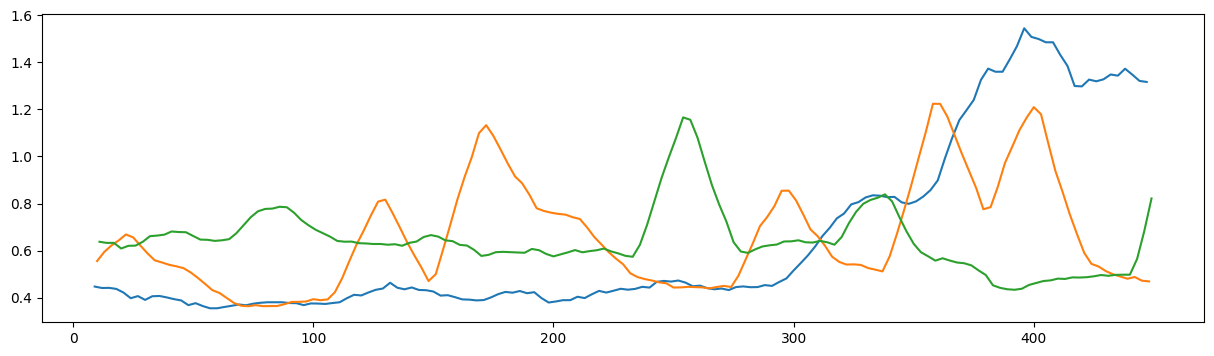

In [124]:
#создадим датафрейм, в который мы будем накапливать временные ряды по странам для анализа корреляций между ними
df_corr = pd.DataFrame()
#зададим размер графика
plt.rcParams['figure.figsize'] = [15, 4]
#создадим объект фигуры
fig = plt.figure()
ax = plt.subplot(111)
# создадим список брендов и общий
list_brand = df['brand_id'].unique()
# в цикле нанесем на график продажи в по брендам
for brand in list_brand:
  # сделаем срез данных по бренду
  df_for_plot = df[df['brand_id'] == brand ]
  # проводим нормализацию данных
  df_sales = (df_for_plot['receipts_count'].groupby(df_for_plot.index).agg('sum').round(2)/df_for_plot['receipts_count'].sum())*100
  # производим декомпозицию временного ряда, устраним недельный тренд
  decomposition = seasonal_decompose(df_sales, period = 7)
  # удаляем пропуски
  trend7 = decomposition.trend.dropna()
  # добавим данные в датафрейм для последующего анализа корреляций
  df_corr[brand] = trend7
  # добавим график на фигуру
  plt.plot(trend7)



In [ ]:
df[df['brand_id'] == 29]['receipts_count'].plot()